# Analyse histopathologique des maladies hépatiques

## Partie 0 - Importation des librairies

In [34]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import visualkeras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.5.0


## Partie 1 - Prétraitement des données

### 1.1.Chargement du dataset par le datagénérateur

In [35]:
# la fonction seed permet de généré les memes résultas lors de l'appel de la fonction random
seed = 2021
random.seed = seed
np.random.seed = seed
tf.seed = seed




class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):  
        
        # Parcour du chemin d'acceé du data_set
        image_path = os.path.join(self.path, id_name, "images/", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)

        # lecture des images
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size)) #128x128

        mask = np.zeros((self.image_size, self.image_size, 1))

        # Lecture des masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            # combinaisson de tous les masques en un seul
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)


        # Normalisation des images et des masks
        image = image/255.0
        mask = mask/255.0

        return image, mask
    
        
                                                            
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

### 1.2.Augmentation de donneés

In [3]:
class DataAugmentation(keras.utils.Sequence):
    train_set = ImageDataGenerator(
        rotation_range=40, # rotation l’image de 40*
        height_shift_range=0.2, # déplace l’image vers la gauche ou la droite horizontalement
        width_shift_range=0.3, # déplace l’image vers la gauche ou la droite verticalement 
        shear_range=0.2, # cisaillement avec angle 20*
        zoom_range=0.5, # zoum l’image 
        horizontal_flip=True, # retournement horizontal de l'image
        fill_mode='nearest')

### 1.3.Ajustemeunt des hyper-paramètres

In [36]:
image_size = 128 # Redimensionner nos images à 128x128
train_path = "C:/Users/kebir/OneDrive/Bureau/data_set/" # chemin d'acceé du data_set
epochs = 10 # nobre d'epoque pour l'entrainement de notre modèle
batch_size = 8 # nobre d'images pour un deul lot de forward_feedback / itterarion
val_data_size = 10 # taille du validation_set
IMG_CHANNELS = 3 # RGB pour les images
MSK_CHANNELS = 1 # GRAY pour les masks



## parcour du training_set par les ids
train_ids = next(os.walk(train_path))[1]

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [37]:
print('Obtention et redimensionnement des images dentraînement et les masks... ')
sys.stdout.flush()

# On génére ici le data_set
gen = DataGen(train_ids, train_path, batch_size=668, image_size=image_size)
x, y = gen.__getitem__(0)
# x represente les images et y les masks

print('taravail terminé voici le résumé : ')
print(x.shape, y.shape)

Obtention et redimensionnement des images dentraînement et les masks... 
taravail terminé voici le résumé : 
(658, 128, 128, 3) (658, 128, 128, 1)


### 1.4.Afichage du dataset

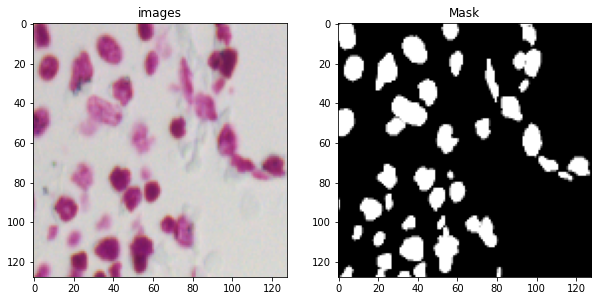

In [75]:
# Affichage d'une image au hasard

r = random.randint(7, len(x)-1)


fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
plt.title("images")
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
plt.title("Mask")
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

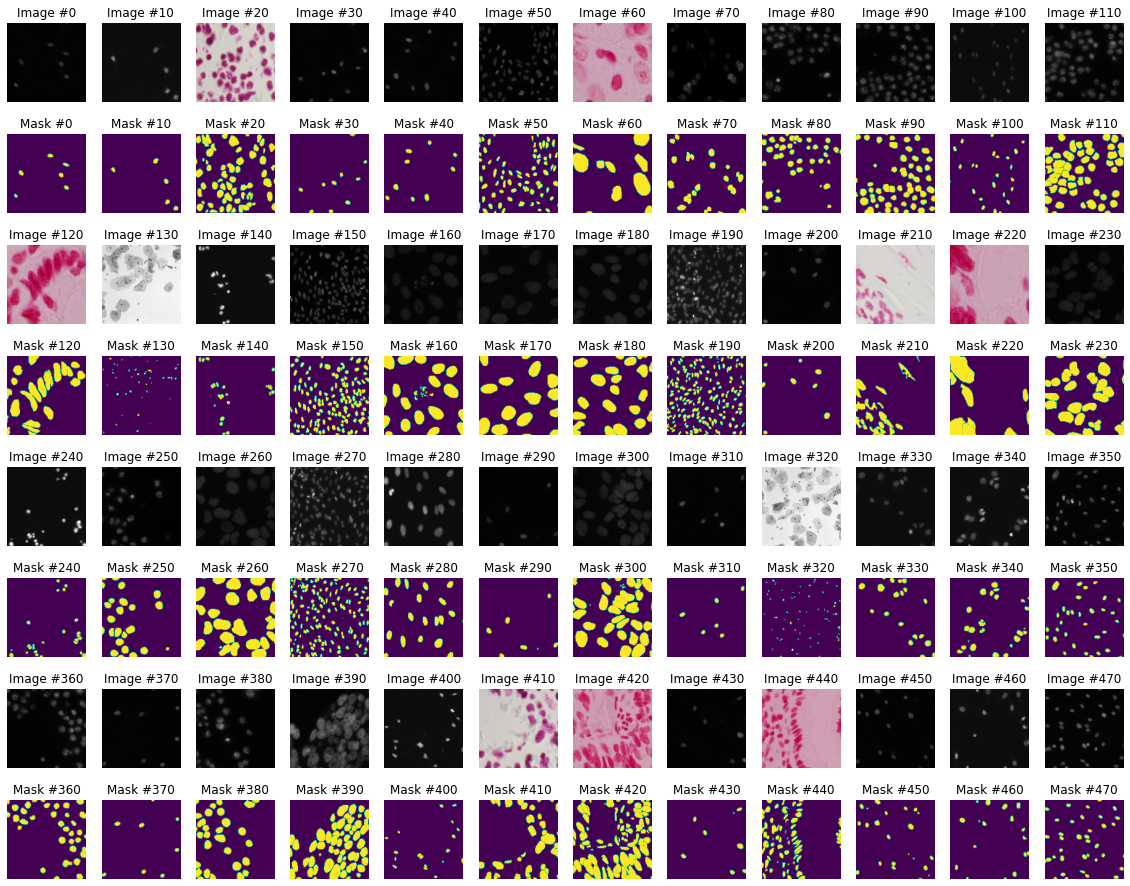

In [23]:
# Illustration de 40 images avec leurs masks respéctives
plt.figure(figsize=(20,16))
x1, y1 = 12,4
for i in range(y1):  
    for j in range(x1):
        plt.subplot(y1*2, x1, i*2*x1+j+1)
        pos = i*120 + j*10
        plt.imshow(x[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y1*2, x1, (i*2+1)*x1+j+1)
        
        plt.imshow(np.squeeze(y[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

## Partie 2 - Construction du modèle UNet personalisé

### 2.1.Construction des blocks

In [24]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=2):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=2):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=2):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [32]:
# IoU ou Intersection over Union ou perte de Jaccard : est une metrique ou mesure d’évaluation.

valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
x_valid, y_valid = valid_gen.__getitem__(1)
result = model.predict(x_valid)


def LossJaccard(y_valid, result):
  intersection=tf.reduce_sum(y_valid*result, axis=(1, 2))
  union       =tf.reduce_sum(y_valid+result, axis=(1, 2))
  jaccard=intersection/(union-intersection+1E-4)
  return 1-jaccard


# Dans model.compile --> loss="model.LossJaccard"

### 2.2.Implementation du modèle

In [71]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, IMG_CHANNELS))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[2]) #64 -> 16
    c3, p3 = down_block(p2, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c3, f[3]) #8 -> 16
    u2 = up_block(u1, c2, f[2]) #16 -> 64
    u3 = up_block(u2, c1, f[0]) #64 -> 128
    u5 = Dropout(0.1) (u4)
    
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"]) #tf.keras.metrics.MeanIoU(num_classes=2)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 128, 128, 16) 448         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_135[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_136[0][0]                 
____________________________________________________________________________________________

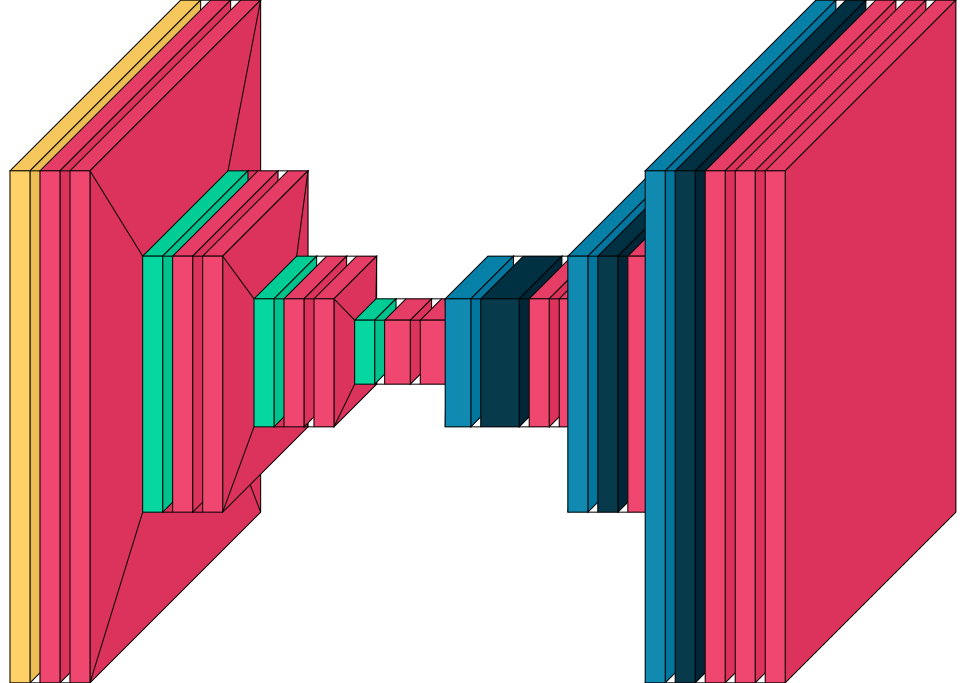

In [69]:
visualkeras.layered_view(model, to_file='UNet_Personalisé_Architecture.png')

### 2.3.Entrainement du modèle

In [27]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

C:\Users\kebir\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
81/81 [==============================] - 134s 2s/step - loss: 0.4106 - acc: 0.8503 - val_loss: 0.3481 - val_acc: 0.8170
Epoch 2/10
81/81 [==============================] - 44s 539ms/step - loss: 0.2432 - acc: 0.8706 - val_loss: 0.3439 - val_acc: 0.8393
Epoch 3/10
81/81 [==============================] - 43s 525ms/step - loss: 0.1432 - acc: 0.9301 - val_loss: 0.3441 - val_acc: 0.8357
Epoch 4/10
81/81 [==============================] - 39s 480ms/step - loss: 0.1432 - acc: 0.9311 - val_loss: 0.2875 - val_acc: 0.8747
Epoch 5/10
81/81 [==============================] - 44s 542ms/step - loss: 0.1671 - acc: 0.9237 - val_loss: 0.2910 - val_acc: 0.8534
Epoch 6/10
81/81 [==============================] - 37s 445ms/step - loss: 0.1303 - acc: 0.9364 - val_loss: 0.2718 - val_acc: 0.8672
Epoch 7/10
81/81 [==============================] - 34s 417ms/step - loss: 0.1335 - acc: 0.9339 - val_loss: 0.2594 - val_acc: 0.8713
Epoch 8/10
81/81 [==============================] - 34s 424ms/step - lo

### 2.4.Teste et prédiction du modèle

In [28]:
# Enregistrement des poid entrainés
model.save_weights("UNetPersonalisé.h5")
print("Modèle sauvgardé")


# prédiction avec le validate_set
x_valid, y_valid = valid_gen.__getitem__(1)
result = model.predict(x_valid)

result = result > 0.5

print(x_valid.shape, y_valid.shape)

Modèle sauvgardé
(4, 128, 128, 3) (4, 128, 128, 1)


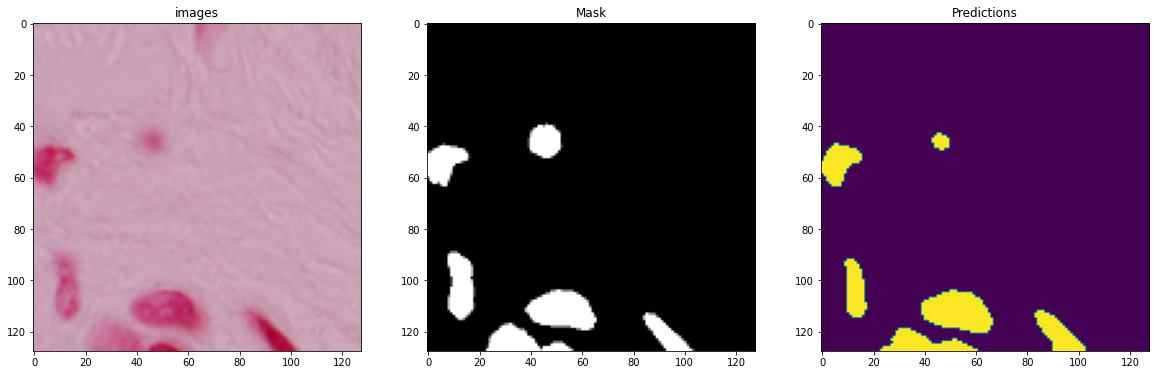

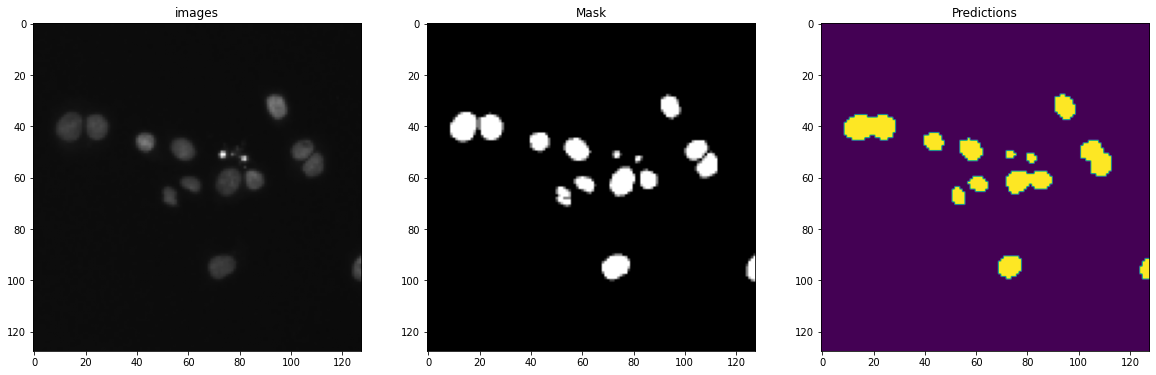

In [29]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax = fig.add_subplot(1, 3, 1)
plt.title("images")
ax.imshow(x_valid[0])

ax = fig.add_subplot(1, 3, 2)
plt.title("Mask")
ax.imshow(np.reshape(y_valid[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
plt.title("Predictions")
ax.imshow(np.squeeze(result[0]))




fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax = fig.add_subplot(1, 3, 1)
plt.title("images")
ax.imshow(x_valid[1])

ax = fig.add_subplot(1, 3, 2)
plt.title("Mask")
ax.imshow(np.reshape(y_valid[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
plt.title("Predictions")
ax.imshow(np.squeeze(result[1]))

### 2.5.Resultats du modèle

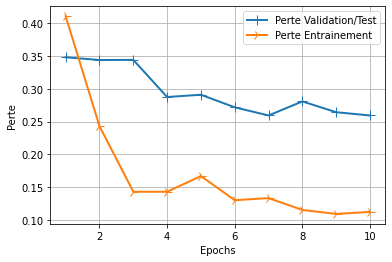

In [30]:
# Perte durant Entrainement & Validation/Test

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Perte Validation/Test')
line2 = plt.plot(epochs, loss_values, label='Perte Entrainement')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Perte')
plt.grid(True)
plt.legend()
plt.show()

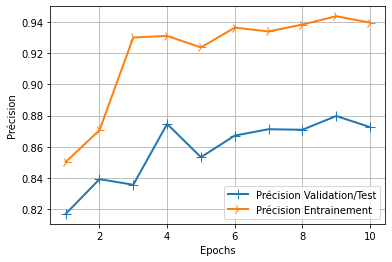

In [31]:
# Précision durant Entrainement & Validation/Test
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Précision Validation/Test')
line2 = plt.plot(epochs, acc_values, label='Précision Entrainement')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Précision')
plt.grid(True)
plt.legend()
plt.show()

## Partie 3 - Construction du modèle InceptionResNetV2-UNet

### 3.1.Construction des blocks

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


#-------------------------------------------------------


def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

### 3.2.Implementation du modèle

In [33]:
def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (128 x 128)

    s2 = encoder.get_layer("activation").output        ## (64 x 64)
    s2 = ZeroPadding2D(( (2, 0), (2, 0) ))(s2)         

    s3 = encoder.get_layer("activation_3").output      ## (32 x 32)
    s3 = ZeroPadding2D((1, 1))(s3)                     

    s4 = encoder.get_layer("activation_74").output      ## (16 x 16)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (8 x 8)
    b1 = ZeroPadding2D((2, 1))(b1)                      

    """ Decoder """
    d1 = decoder_block(b1, s4, 128)                     ## (16 x 16)
    d2 = decoder_block(d1, s3, 64)                      ## (32 x 32)
    d3 = decoder_block(d2, s2, 32)                      ## (64 x 64)
    d4 = decoder_block(d3, s1, 8)                       ## (128 x 128)      

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="InceptionResNetV2_U-Net")
    return model
    

    
    
input_shape = (128, 128, 3)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model = build_inception_resnetv2_unet(input_shape)
model.summary()

Model: "InceptionResNetV2_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________

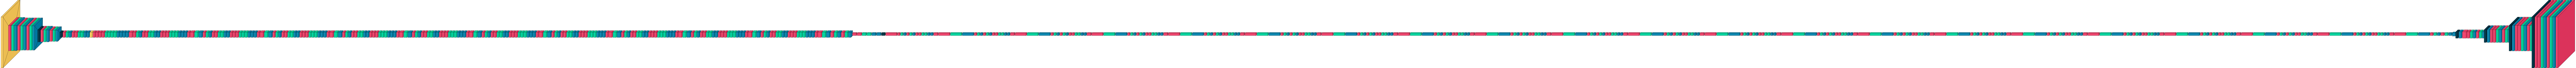

In [34]:
visualkeras.layered_view(model, to_file='02.png')

### 3.3.Entrainement du modèle

In [39]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/5
82/82 [==============================] - 214s 2s/step - loss: 0.1113 - acc: 0.9498 - val_loss: 0.0597 - val_acc: 0.9677
Epoch 2/5
82/82 [==============================] - 121s 1s/step - loss: 0.0998 - acc: 0.9504 - val_loss: 0.0578 - val_acc: 0.9658
Epoch 3/5
82/82 [==============================] - 89s 1s/step - loss: 0.0873 - acc: 0.9540 - val_loss: 0.0481 - val_acc: 0.9683
Epoch 4/5
82/82 [==============================] - 105s 1s/step - loss: 0.0906 - acc: 0.9522 - val_loss: 0.1217 - val_acc: 0.9467
Epoch 5/5
82/82 [==============================] - 79s 965ms/step - loss: 0.0968 - acc: 0.9490 - val_loss: 0.0998 - val_acc: 0.9650


### 3.4.Teste et prédiction du modèle

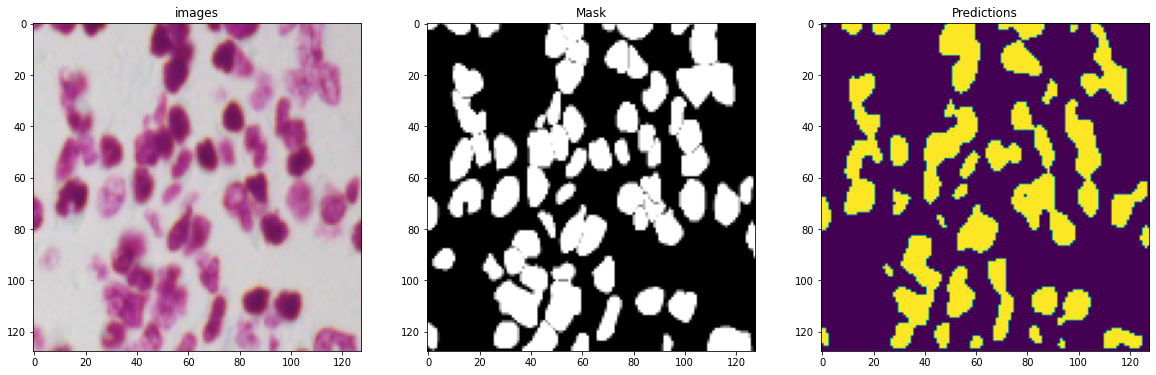

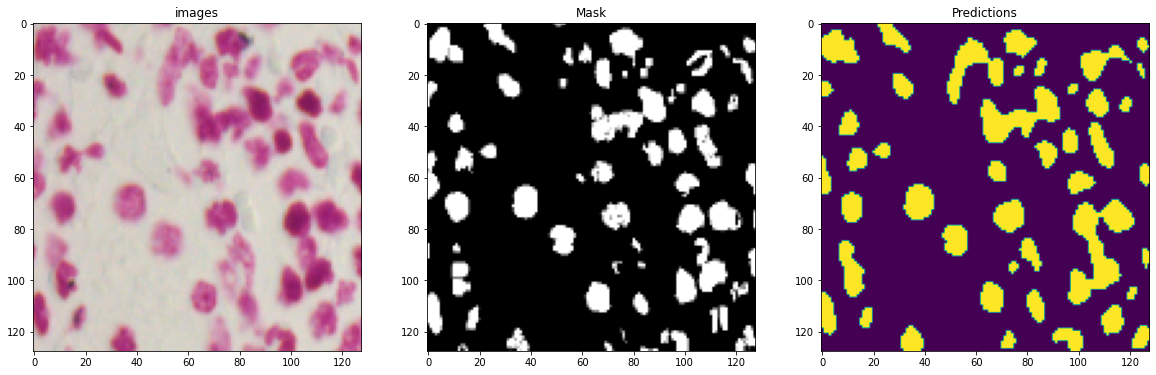

In [44]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax = fig.add_subplot(1, 3, 1)
plt.title("images")
ax.imshow(x_valid[0])

ax = fig.add_subplot(1, 3, 2)
plt.title("Mask")
ax.imshow(np.reshape(y_valid[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
plt.title("Predictions")
ax.imshow(np.squeeze(result[0]))




fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax = fig.add_subplot(1, 3, 1)
plt.title("images")
ax.imshow(x_valid[1])

ax = fig.add_subplot(1, 3, 2)
plt.title("Mask")
ax.imshow(np.reshape(y_valid[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
plt.title("Predictions")
ax.imshow(np.squeeze(result[1]))

### 3.5.Resultats du modèle

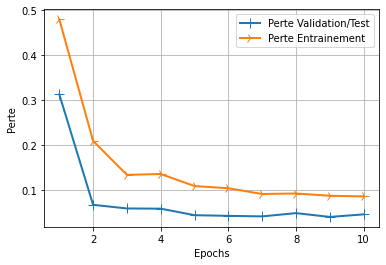

In [45]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Perte Validation/Test')
line2 = plt.plot(epochs, loss_values, label='Perte Entrainement')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Perte')
plt.grid(True)
plt.legend()
plt.show()

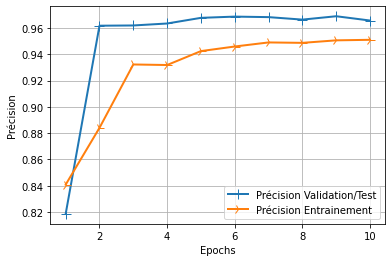

In [46]:
history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Précision Validation/Test')
line2 = plt.plot(epochs, acc_values, label='Précision Entrainement')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Précision')
plt.grid(True)
plt.legend()
plt.show()